In [97]:
import pandas as pd
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [47]:
def read_tab_file(filename):
    '''
    The output of the MTP shotgun pipeline includes a '.tab' file which lists the abundances and the taxonomies. 
    This method parses it to a dict
    '''
    out = {} # will be organized by level (kingdom / phylum / species etc)
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith(">>>"):
                name = line.split(' ')[1]
                out[name] = {}
                #check if the line starts with a letter
            elif re.findall('^[a-zA-Z]+', line[0]):
                try:
                    taxon, cg_reads, abud, taxonomy = line.rstrip().split('\t')
                except ValueError:
                    #Kingdom line doesn't have a taxonomy list since it's the first
                    taxon, cg_reads, abud = line.rstrip().split('\t')
                    taxonomy = ''
                out[name][taxon] = [int(cg_reads), float(abud), taxonomy]
    return out

#From Gabi's Jupyter Notebook
def get_count_df(tabpath, taxonomy_info={}):
    samp_name = tabpath.split('/')[-1].split('.')[0]
    level_dict = read_tab_file(tabpath)
    species_dict = level_dict['Species']

    if not species_dict:
        print(f'No results for {samp_name}')
        return None, taxonomy_info

    species_df = pd.DataFrame.from_dict(species_dict, orient='index')
    species_df.columns = ['Core Gene Reads', 'Abundance', 'Taxonomy']

    #prep the individual cg and ab dfs for this sample to concat later
    #cg_df = species_df[['Core Gene Reads']]
    cg_df = species_df[['Abundance']]
    cg_df.columns = [samp_name]
    
    return cg_df

#From Gabi's Jupyter Notebook
def make_df(files):
    counts = []
    for file in files:
        count_df = get_count_df(file, {})
        counts.append(count_df)
    return pd.concat(counts, axis=1).fillna(0)

In [48]:
ovw_files = glob.glob('../ovw/*/*.tab')
nor_files = glob.glob('../nor/*/*.tab')

ovw_df = make_df(ovw_files)
nor_df = make_df(nor_files)
sum_ovw_df = ovw_df.sum(axis=1)
sum_nor_df = nor_df.sum(axis=1)
sum_ovw_df = sum_ovw_df.sort_values(ascending=False)
sum_nor_df = sum_nor_df.sort_values(ascending=False)

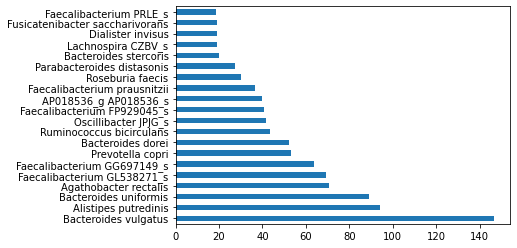

In [49]:
sum_ovw_df.head(20).plot(kind='barh')
plt.show()

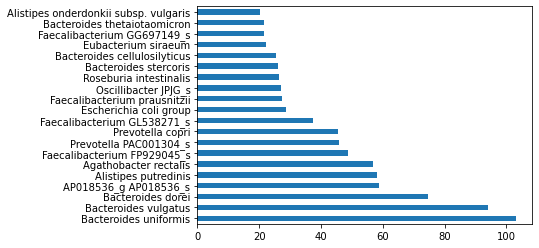

In [50]:
sum_nor_df.head(20).plot(kind='barh')
plt.show()

In [51]:
ovw_set = set(sum_ovw_df.index)
nor_set = set(sum_nor_df.index)
exc_ovw_set = ovw_set - nor_set
exc_nor_set = nor_set - ovw_set
exc_ovw_df = sum_ovw_df[list(exc_ovw_set)] #passing uncasted set is deprecated
exc_nor_df = sum_nor_df[list(exc_nor_set)]
exc_ovw_df = exc_ovw_df.sort_values(ascending=False)
exc_nor_df = exc_nor_df.sort_values(ascending=False)

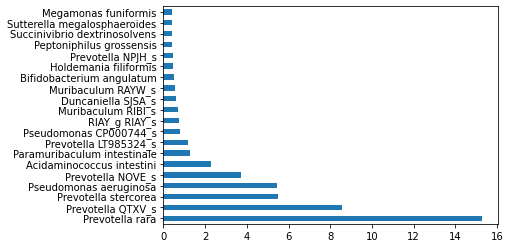

In [52]:
exc_ovw_df.head(20).plot(kind='barh')
plt.show()

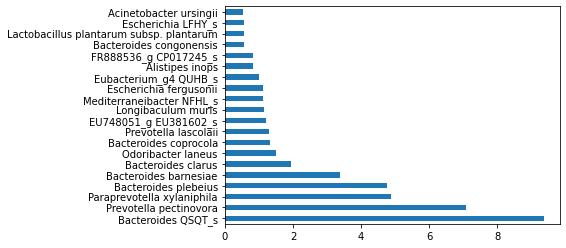

In [53]:
exc_nor_df.head(20).plot(kind='barh')
plt.show()

In [54]:
exc_nor_df

Bacteroides QSQT_s            9.362237
Prevotella pectinovora        7.087783
Paraprevotella xylaniphila    4.885054
Bacteroides plebeius          4.763370
Bacteroides barnesiae         3.374128
                                ...   
Lactobacillus rhamnosus       0.054604
Prevotella colorans           0.049983
Butyricimonas synergistica    0.043635
Massilioclostridium coli      0.041800
Urinacoccus massiliensis      0.038900
Length: 90, dtype: float64

<AxesSubplot:>

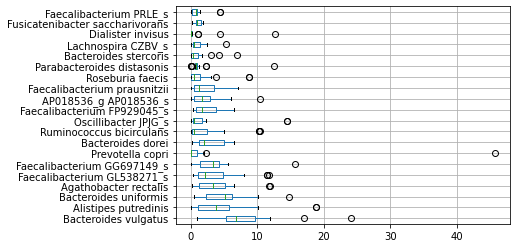

In [55]:
top_ovw = sum_ovw_df.head(20).index
ovw_df.loc[top_ovw].T.boxplot(vert=False)

<AxesSubplot:>

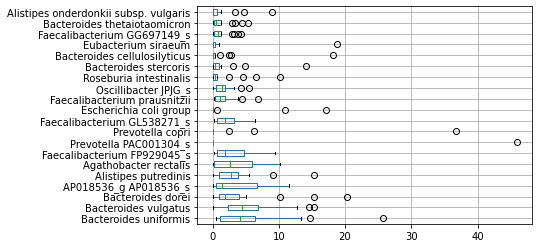

In [56]:
top_nor = sum_nor_df.head(20).index
nor_df.loc[top_nor].T.boxplot(vert=False)

C:\Users\juno\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


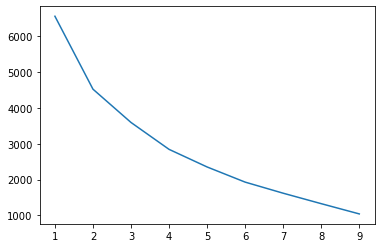

In [74]:
inertias = []
for x in range(1, 10):
    kmeans = KMeans(n_clusters=x)
    kmeans.fit(ovw_df.T)
    inertias.append(kmeans.inertia_)
plt.plot(range(1,10),inertias)

C:\Users\juno\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


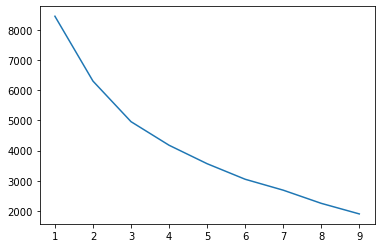

In [75]:
inertias = []
for x in range(1, 10):
    kmeans = KMeans(n_clusters=x)
    kmeans.fit(nor_df.T)
    inertias.append(kmeans.inertia_)
plt.plot(range(1,10),inertias)

In [183]:
ovw_kmeans = KMeans(n_clusters=5)
ovw_clusters = ovw_kmeans.fit_predict(ovw_df.T)
ovw_centroids = ovw_kmeans.cluster_centers_
ovw_clusters

array([0, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 1, 2, 4, 0, 1, 4, 2])

In [184]:
nor_kmeans = KMeans(n_clusters=5)
nor_clusters = nor_kmeans.fit_predict(nor_df.T)
nor_centroids = nor_kmeans.cluster_centers_
nor_clusters

array([0, 3, 4, 3, 0, 3, 1, 2, 3, 0, 3, 0, 2, 0, 3, 3, 3])

0 [ 1.24741359 -4.95349081 -3.08426008 -2.25811702 -3.91432682 -2.89886685
 -3.91973674 -3.23990098 -2.62723757 -2.60845976] [-0.36500109 -5.70228434 -2.18844142 -3.05249291  0.11649299  0.47883476
 -2.43214607 -1.40974401 -0.03260857 -0.04310344]
1 [1.10725199 1.14172497] [-5.0742209  -5.10722872]
2 [-1.47323182 -1.47145528] [-11.34326605 -11.31631819]
3 [43.57088295] [3.1879142]
4 [-5.24354831 -5.23091177 -4.14372968] [14.27479859 14.25961597 15.74919923]


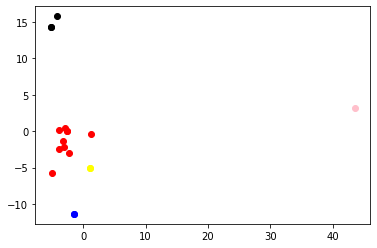

In [192]:
ovwpca = PCA(2).fit_transform(ovw_df.T)
labels = np.unique(ovw_clusters)
colors = ['red', 'yellow', 'blue', 'pink', 'black']
for i in labels:
    print(i, ovwpca[ovw_clusters==i, 0], ovwpca[ovw_clusters==i, 1])
    plt.scatter(ovwpca[ovw_clusters==i, 0], ovwpca[ovw_clusters==i, 1], c=colors[i])

0 [-3.8454726  -2.9058887  -4.55745534 -2.7439335  -5.61675922] [ -6.78248448  -4.44159838  -6.96829957  -4.6909684  -10.43058034]
1 [44.84152342] [-1.26580955]
2 [-1.29753328 -4.60155979] [ 2.88406648 -3.27784716]
3 [-1.46990208 -1.927908   -3.53555889 -1.46692899 -3.34641862 -1.07333348
 -2.53638288 -1.26277929] [ 0.5322555  -1.0608194  -3.09716296 -0.14295914  6.3237844  -1.86429326
 -0.2919975   0.69347652]
4 [-2.65370874] [33.88123723]


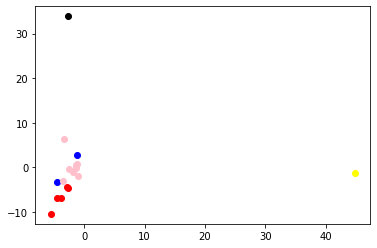

In [193]:
norpca = PCA(2).fit_transform(nor_df.T)
labels = np.unique(nor_clusters)
for i in labels:
    print(i, norpca[nor_clusters==i, 0], norpca[nor_clusters==i, 1])
    plt.scatter(norpca[nor_clusters==i, 0], norpca[nor_clusters==i, 1], c=colors[i])

In [121]:
norpca

array([[ -3.8454726 ,  -6.78248448],
       [ -1.46990208,   0.5322555 ],
       [ -2.65370874,  33.88123723],
       [ -1.927908  ,  -1.0608194 ],
       [ -2.9058887 ,  -4.44159838],
       [ -3.53555889,  -3.09716296],
       [ 44.84152342,  -1.26580955],
       [ -1.29753328,   2.88406648],
       [ -1.46692899,  -0.14295914],
       [ -4.55745534,  -6.96829957],
       [ -3.34641862,   6.3237844 ],
       [ -2.7439335 ,  -4.6909684 ],
       [ -4.60155979,  -3.27784716],
       [ -5.61675922, -10.43058034],
       [ -1.07333348,  -1.86429326],
       [ -2.53638288,  -0.2919975 ],
       [ -1.26277929,   0.69347652]])